In [1]:
from os import environ
environ['TF_CPP_MIN_LOG_LEVEL'] = '2' # Deactive warnings about building from sourc
from scipy.misc import imread, imresize
from glob import glob
import numpy as np
from datetime import datetime

from models import two_layer_convnet
from pymvtest import classification

### Master Dictionary

In [2]:
TF = {
      'batch_size':32,
      'graph':None,
      'image_size':200, # Resize full images to this size
      'patch_size':20,
      'input_channels':1,
      'learning_rate':0.001,
      'n_classes':2,
      'output_channels':[16, 8, 32],
      'filter_size':[3, 5],
      'seed':3,
      'split_fraction':0.7,
      'summary_train':[],
      'training_steps':10001,
      'test_id':'New_Build',
}
print('Training for {} iterations.'.format(TF['training_steps']))
print('{} units per batch.'.format(TF['batch_size']))

Training for 10001 iterations.
32 units per batch.


### Data Import

In [3]:
print('Importing data...')

# Whiten on import
images = np.array([np.expand_dims((imread(fp).astype(np.float32) - 128)/255, axis = -1)
                  for fp in glob('./data/resized-images/*.png')])
masks  = np.array([imread(fp)/255 for fp in glob('./data/masked-images/*.png')])
# Resize to 200 x 200
images, masks = classification.resize(images, masks, TF['image_size'])

print('Data imported and resized.')

Importing data...
Data imported and resized.


### Fit Model

In [4]:
TF = two_layer_convnet.model(TF)
tester = classification.Tester(images, masks, TF)
tester.fit_model()

Training dataset dimensions: (41, 200, 200, 1)
Validation dataset dimensions: (11, 200, 200, 1)

Fitting model...
(Step   0  ) Validation accuracy:    0.49

(Step  100 ) Minibatch accuracy:     0.62
(Step  100 ) Minibatch loss:       0.6864
(Step  100 ) Validation accuracy:    0.55

(Step  200 ) Minibatch accuracy:     0.56
(Step  200 ) Minibatch loss:       0.6686
(Step  200 ) Validation accuracy:    0.74

(Step  300 ) Minibatch accuracy:     0.47
(Step  300 ) Minibatch loss:       0.6585
(Step  300 ) Validation accuracy:    0.62

(Step  400 ) Minibatch accuracy:     0.47
(Step  400 ) Minibatch loss:       0.6141
(Step  400 ) Validation accuracy:    0.80

(Step  500 ) Minibatch accuracy:     0.84
(Step  500 ) Minibatch loss:       0.4713
(Step  500 ) Validation accuracy:    0.81

(Step  600 ) Minibatch accuracy:     0.69
(Step  600 ) Minibatch loss:       0.6334
(Step  600 ) Validation accuracy:    0.82

(Step  700 ) Minibatch accuracy:     0.75
(Step  700 ) Minibatch loss:       0.43

### Query Model

In [11]:
query_images = images[0:2, :, :, :]
query_masks  = masks[0:2, :, :]
predictions, query_masks = tester.query_model(query_images, query_masks)

INFO:tensorflow:Restoring parameters from ./checkpoints/New_Build.ckpt


In [6]:
import matplotlib.pyplot as plt
%matplotlib inline

In [7]:
predictions.shape

(2, 200, 200)

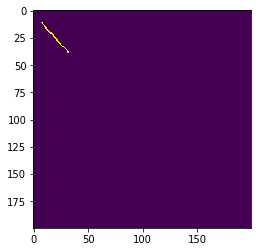

In [12]:
plt.imshow(masks[0, :, :]);

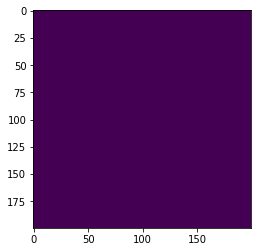

In [13]:
plt.imshow(predictions[1, :, :])

In [14]:
import tensorflow as tf

In [22]:
with tf.Session(graph = tester.tf_graph) as session:

    tester.tf_saver.restore(session, './checkpoints/'+tester.test_id+'.ckpt')

    predictions = np.zeros_like(images, dtype = 'float32').flatten()

    for j, ix in enumerate(np.array(np.nonzero(np.ones_like(masks))).T):
        ix               = np.array([ix])
        q_patch, q_label = classification.get_patches(images, masks, ix, tester.patch_size)
        fd               = {tester.tf_data:q_patch, tester.tf_labels:q_label}
        predictions[j]   = session.run(tester.tf_predictions, feed_dict = fd)[0, 1]

    predictions = predictions.reshape(masks.shape)

INFO:tensorflow:Restoring parameters from ./checkpoints/New_Build.ckpt


KeyboardInterrupt: 

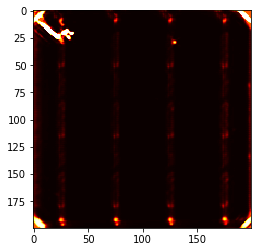

In [80]:
plt.imshow(predictions.reshape(masks.shape)[3,:,:], cmap = 'hot');

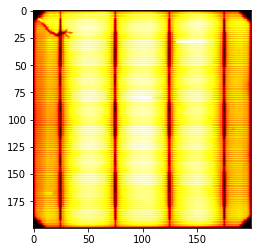

In [81]:
plt.imshow(images[3, :, :, 0], cmap = 'hot');